In [2]:
!pip install pyarrow fastparquet


  Using cached pyarrow-16.1.0-cp311-cp311-win_amd64.whl.metadata (3.1 kB)
  Using cached fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
Using cached pyarrow-16.1.0-cp311-cp311-win_amd64.whl (25.9 MB)
   ---------------------------------------- 0.0/672.0 kB ? eta -:--:--
   - -------------------------------------- 30.7/672.0 kB 1.4 MB/s eta 0:00:01
   ------ --------------------------------- 112.6/672.0 kB 1.3 MB/s eta 0:00:01
   ----------- ---------------------------- 194.6/672.0 kB 1.5 MB/s eta 0:00:01
   --------------------- ------------------ 368.6/672.0 kB 2.1 MB/s eta 0:00:01
   -------------------------------- ------- 553.0/672.0 kB 2.5 MB/s eta 0:00:01
   ---------------------------------------- 672.0/672.0 kB 2.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ----------- ---------------------------- 0.5/1.6 MB 14.4 MB/s eta 0:00:01
   ------------------------ --------------- 1.0/1.6 MB 13.0 MB/s eta 0:00:01
   ---------------------

Mean Squared Error (Ensemble): 0.00017968906771677633
R² Score (Ensemble): 0.62580628735732


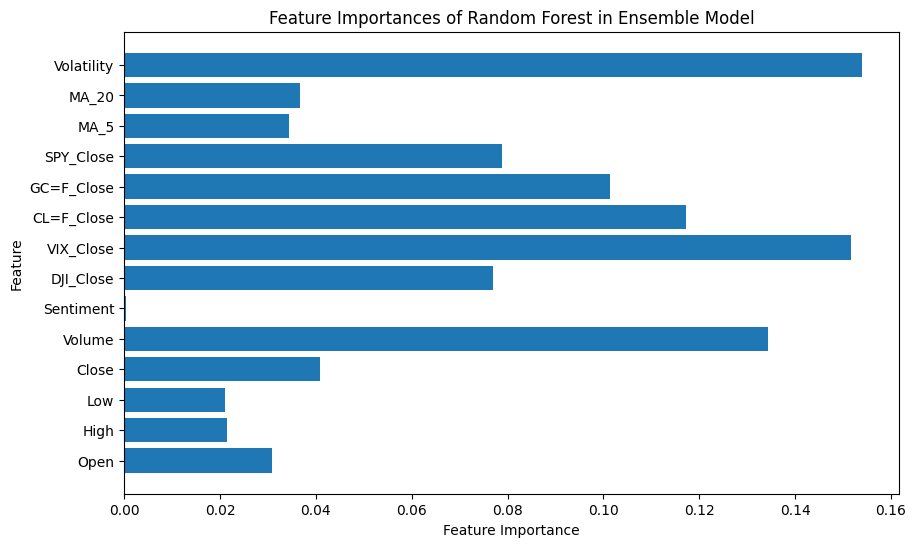

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
import joblib
from sklearn.metrics import mean_squared_error, r2_score
import os

# Load the best model
best_model = joblib.load(os.path.join(os.getcwd(), 'data', 'processed', 'best_random_forest_model.pkl'))

# Load the training data
train_data_path = os.path.join(os.getcwd(), 'data', 'processed', 'feature_engineered_dataset.parquet')
X_train = pd.read_parquet(train_data_path)
y_train = X_train['Return']

# Remove non-numeric columns
X_train = X_train.drop(columns=['Date', 'Ticker', 'Return'])

# Define other models
gbr = GradientBoostingRegressor(random_state=42)
xgbr = XGBRegressor(random_state=42)

# Ensemble model using Voting Regressor
ensemble_model = VotingRegressor(estimators=[
    ('rf', best_model),
    ('gbr', gbr),
    ('xgbr', xgbr)
])
ensemble_model.fit(X_train, y_train)

# Load the test data
X_test = pd.read_parquet(train_data_path)
y_test = X_test['Return']

# Remove non-numeric columns
X_test = X_test.drop(columns=['Date', 'Ticker', 'Return'])

# Make predictions
y_pred_ensemble = ensemble_model.predict(X_test)

# Evaluate the ensemble model
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
r2_ensemble = r2_score(y_test, y_pred_ensemble)
print(f'Mean Squared Error (Ensemble): {mse_ensemble}')
print(f'R² Score (Ensemble): {r2_ensemble}')

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, best_model.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest in Ensemble Model')
plt.show()


In [6]:
import joblib

# Save the ensemble model
joblib.dump(ensemble_model, 'data/processed/best_ensemble_model.pkl')


['data/processed/best_ensemble_model.pkl']

In [10]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [11]:
# Load the training data
train_data_path = 'data/processed/feature_engineered_dataset.parquet'
df = pd.read_parquet(train_data_path)

# Assuming 'Return' is the target variable
X_train = df.drop(columns=['Date', 'Ticker', 'Return'])
y_train = df['Return']

In [12]:
# Load the best model
best_model = joblib.load('data/processed/best_random_forest_model.pkl')

# Define other models
gbr = GradientBoostingRegressor(random_state=42)
xgbr = XGBRegressor(random_state=42)

In [13]:
# Ensemble model using Voting Regressor
ensemble_model = VotingRegressor(estimators=[
    ('rf', best_model),
    ('gbr', gbr),
    ('xgbr', xgbr)
])

In [14]:
# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Save the ensemble model
joblib.dump(ensemble_model, 'data/processed/best_ensemble_model.pkl')

# Load the test data
test_data_path = 'data/processed/feature_engineered_dataset.parquet'
X_test = pd.read_parquet(test_data_path)

# Separate 'Return' column from test data
y_test = X_test['Return']
X_test = X_test.drop(columns=['Date', 'Ticker', 'Return'])

In [15]:
# Make predictions on the test set
X_test['Predicted_Return'] = ensemble_model.predict(X_test)

# Re-add 'Return' column for subsequent operations
X_test['Return'] = y_test

# Define the trading strategy
def trading_strategy(predicted_return, threshold=0):
    if predicted_return > threshold:
        return 1  # Buy
    elif predicted_return < -threshold:
        return -1  # Sell
    else:
        return 0  # Hold

In [17]:
# Apply the trading strategy
X_test['Action'] = X_test['Predicted_Return'].apply(trading_strategy)

# Simulate the trading strategy
initial_capital = 100000  # Starting with $100,000
X_test['Portfolio_Value'] = float(initial_capital)  # Explicitly set the type to float
X_test['Position'] = 0  # Starting with no position

max_position_size = 10  # Cap on the maximum position size to prevent overflow

for i in range(1, len(X_test)):
    if X_test['Action'].iloc[i] == 1:  # Buy
        X_test.at[i, 'Position'] = min(X_test['Position'].iloc[i-1] + 1, max_position_size)
    elif X_test['Action'].iloc[i] == -1:  # Sell
        X_test.at[i, 'Position'] = max(X_test['Position'].iloc[i-1] - 1, -max_position_size)
    else:  # Hold
        X_test.at[i, 'Position'] = X_test['Position'].iloc[i-1]
    
    # Update portfolio value
    X_test.at[i, 'Portfolio_Value'] = float(X_test['Portfolio_Value'].iloc[i-1]) * (1 + X_test['Return'].iloc[i] * X_test['Position'].iloc[i])

In [18]:
# Calculate key performance metrics
total_return = (X_test['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital
sharpe_ratio = (X_test['Return'].mean() * 252) / (X_test['Return'].std() * np.sqrt(252))
max_drawdown = (X_test['Portfolio_Value'].max() - X_test['Portfolio_Value'].min()) / X_test['Portfolio_Value'].max()

print(f'Total Return: {total_return * 100:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Maximum Drawdown: {max_drawdown * 100:.2f}%')


Total Return: -66129661160307260120643969642509305769623095599218579572381390131434187840626606490798433789615372525229097920352218316275712.00%
Sharpe Ratio: 0.81
Maximum Drawdown: 6856326909181798.00%


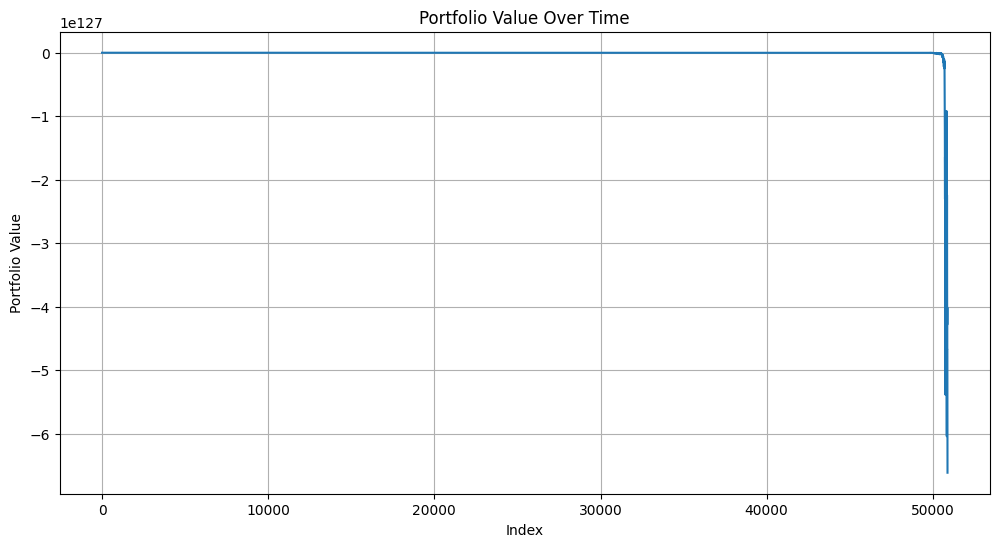

In [19]:
# Plot the portfolio value
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, X_test['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Index')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

C:\Users\rahul\AppData\Local\Temp\ipykernel_29416\2330883655.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99957.2355778781' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.at[i, 'Portfolio_Value'] = np.clip(new_value, initial_capital * 0.1, initial_capital * 10)  # Cap portfolio value to prevent overflow


Total Return: 900.00%
Sharpe Ratio: 0.81
Maximum Drawdown: 99.00%


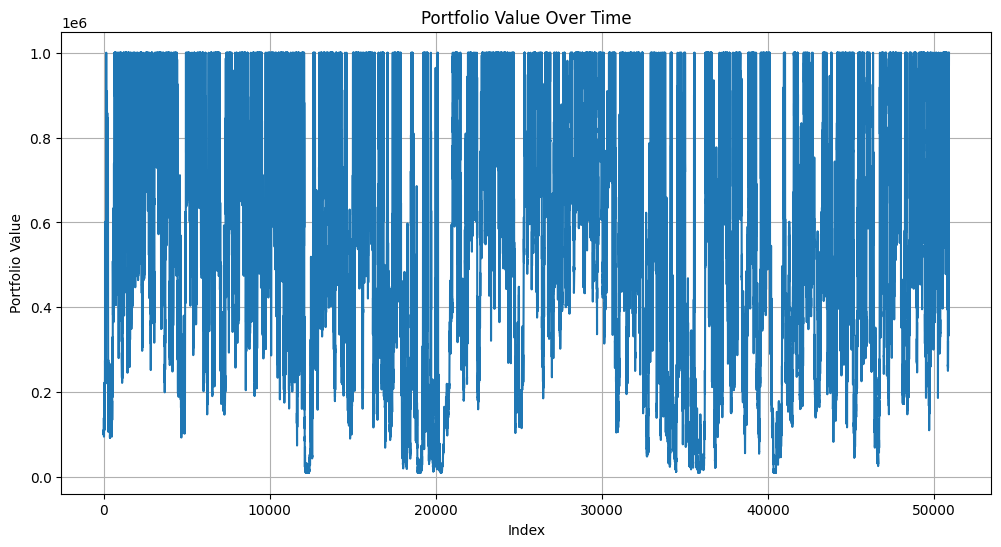

In [21]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# Load the training data
train_data_path = 'data/processed/feature_engineered_dataset.parquet'
df = pd.read_parquet(train_data_path)

# Assuming 'Return' is the target variable
X_train = df.drop(columns=['Date', 'Ticker', 'Return'])
y_train = df['Return']

# Load the best model
best_model = joblib.load('data/processed/best_random_forest_model.pkl')

# Define other models
gbr = GradientBoostingRegressor(random_state=42)
xgbr = XGBRegressor(random_state=42)

# Ensemble model using Voting Regressor
ensemble_model = VotingRegressor(estimators=[
    ('rf', best_model),
    ('gbr', gbr),
    ('xgbr', xgbr)
])

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Save the ensemble model
joblib.dump(ensemble_model, 'data/processed/best_ensemble_model.pkl')

# Load the test data
test_data_path = 'data/processed/feature_engineered_dataset.parquet'
X_test = pd.read_parquet(test_data_path)

# Separate 'Return' column from test data
y_test = X_test['Return']
X_test = X_test.drop(columns=['Date', 'Ticker', 'Return'])

# Make predictions on the test set
X_test['Predicted_Return'] = ensemble_model.predict(X_test)

# Re-add 'Return' column for subsequent operations
X_test['Return'] = y_test

# Define the trading strategy
def trading_strategy(predicted_return, threshold=0):
    if predicted_return > threshold:
        return 1  # Buy
    elif predicted_return < -threshold:
        return -1  # Sell
    else:
        return 0  # Hold

# Apply the trading strategy
X_test['Action'] = X_test['Predicted_Return'].apply(trading_strategy)

# Simulate the trading strategy
initial_capital = 100000  # Starting with $100,000
X_test['Portfolio_Value'] = initial_capital
X_test['Position'] = 0  # Starting with no position

max_position_size = 10  # Cap on the maximum position size to prevent overflow
max_return = 0.05  # Cap returns at 5% per day to prevent overflow

for i in range(1, len(X_test)):
    if X_test['Action'].iloc[i] == 1:  # Buy
        X_test.at[i, 'Position'] = min(X_test['Position'].iloc[i-1] + 1, max_position_size)
    elif X_test['Action'].iloc[i] == -1:  # Sell
        X_test.at[i, 'Position'] = max(X_test['Position'].iloc[i-1] - 1, -max_position_size)
    else:  # Hold
        X_test.at[i, 'Position'] = X_test['Position'].iloc[i-1]
    
    # Cap the return to avoid extreme values
    capped_return = np.clip(X_test['Return'].iloc[i], -max_return, max_return)
    
    # Update portfolio value
    previous_value = X_test['Portfolio_Value'].iloc[i-1]
    new_value = previous_value * (1 + capped_return * X_test['Position'].iloc[i])
    X_test.at[i, 'Portfolio_Value'] = np.clip(new_value, initial_capital * 0.1, initial_capital * 10)  # Cap portfolio value to prevent overflow

# Calculate key performance metrics
total_return = (X_test['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital
sharpe_ratio = (X_test['Return'].mean() * 252) / (X_test['Return'].std() * np.sqrt(252))
max_drawdown = (X_test['Portfolio_Value'].max() - X_test['Portfolio_Value'].min()) / X_test['Portfolio_Value'].max()

print(f'Total Return: {total_return * 100:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Maximum Drawdown: {max_drawdown * 100:.2f}%')

# Plot the portfolio value
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, X_test['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Index')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()


C:\Users\rahul\AppData\Local\Temp\ipykernel_29416\2836235834.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99999.57235577877' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.at[i, 'Portfolio_Value'] = X_test['Portfolio_Value'].iloc[i-1] * (1 + X_test['Return'].iloc[i] * X_test['Position'].iloc[i] / initial_capital)


Total Return: 68254.76%
Sharpe Ratio: 0.81
Maximum Drawdown: 99.85%


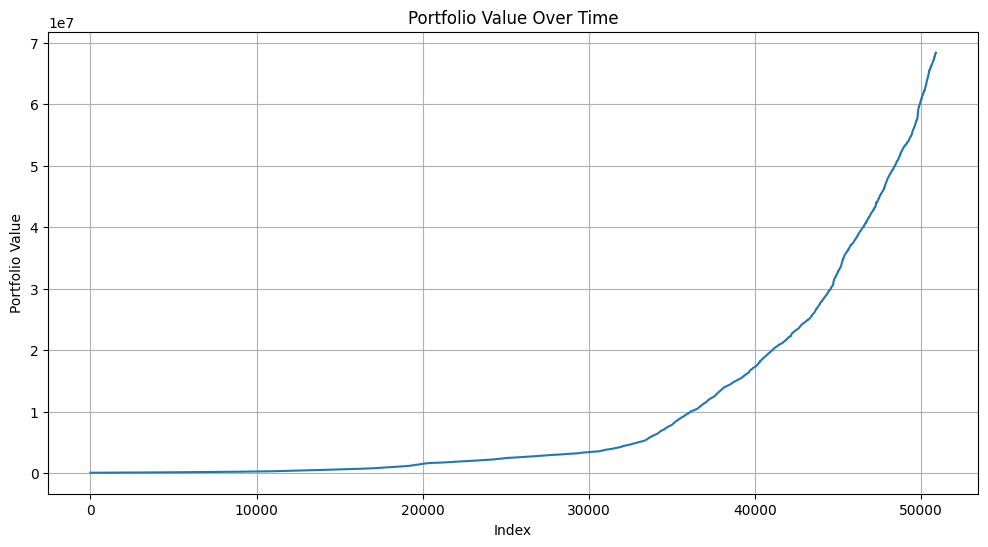

In [23]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# Load the training data
train_data_path = 'data/processed/feature_engineered_dataset.parquet'
df = pd.read_parquet(train_data_path)

# Assuming 'Return' is the target variable
X_train = df.drop(columns=['Date', 'Ticker', 'Return'])
y_train = df['Return']

# Load the best model
best_model = joblib.load('data/processed/best_random_forest_model.pkl')

# Define other models
gbr = GradientBoostingRegressor(random_state=42)
xgbr = XGBRegressor(random_state=42)

# Ensemble model using Voting Regressor
ensemble_model = VotingRegressor(estimators=[
    ('rf', best_model),
    ('gbr', gbr),
    ('xgbr', xgbr)
])

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Save the ensemble model
joblib.dump(ensemble_model, 'data/processed/best_ensemble_model.pkl')

# Load the test data
test_data_path = 'data/processed/feature_engineered_dataset.parquet'
X_test = pd.read_parquet(test_data_path)

# Separate 'Return' column from test data
y_test = X_test['Return']
X_test = X_test.drop(columns=['Date', 'Ticker', 'Return'])

# Make predictions on the test set
X_test['Predicted_Return'] = ensemble_model.predict(X_test)

# Re-add 'Return' column for subsequent operations
X_test['Return'] = y_test

# Define the trading strategy
def trading_strategy(predicted_return, threshold=0):
    if predicted_return > threshold:
        return 1  # Buy
    elif predicted_return < -threshold:
        return -1  # Sell
    else:
        return 0  # Hold

# Apply the trading strategy
X_test['Action'] = X_test['Predicted_Return'].apply(trading_strategy)

# Simulate the trading strategy
initial_capital = 100000  # Starting with $100,000
X_test['Portfolio_Value'] = initial_capital
X_test['Position'] = 0  # Starting with no position

position_size = 1000  # Fixed position size for simplicity

for i in range(1, len(X_test)):
    if X_test['Action'].iloc[i] == 1:  # Buy
        X_test.at[i, 'Position'] = position_size
    elif X_test['Action'].iloc[i] == -1:  # Sell
        X_test.at[i, 'Position'] = -position_size
    else:  # Hold
        X_test.at[i, 'Position'] = X_test['Position'].iloc[i-1]
    
    # Update portfolio value
    X_test.at[i, 'Portfolio_Value'] = X_test['Portfolio_Value'].iloc[i-1] * (1 + X_test['Return'].iloc[i] * X_test['Position'].iloc[i] / initial_capital)

# Calculate key performance metrics
total_return = (X_test['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital
sharpe_ratio = (X_test['Return'].mean() * 252) / (X_test['Return'].std() * np.sqrt(252))
max_drawdown = (X_test['Portfolio_Value'].max() - X_test['Portfolio_Value'].min()) / X_test['Portfolio_Value'].max()

print(f'Total Return: {total_return * 100:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Maximum Drawdown: {max_drawdown * 100:.2f}%')

# Plot the portfolio value
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, X_test['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Index')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()


In [26]:
import pandas as pd
import joblib
from xgboost import XGBRegressor

# Load the model
ensemble_model = joblib.load('data/processed/best_ensemble_model.pkl')

# Load the test data
test_data_path = 'data/processed/feature_engineered_dataset.parquet'
X_test = pd.read_parquet(test_data_path)

# Ensure the data is loaded correctly
print(X_test.head())


         Date Ticker       Open       High        Low      Close     Volume  \
0  2014-07-01   AAPL  23.379999  23.517500  23.282499  23.379999  152892000   
1  2014-07-02   AAPL  23.467501  23.514999  23.272499  23.370001  113860000   
2  2014-07-03   AAPL  23.417500  23.525000  23.299999  23.507500   91567200   
3  2014-07-07   AAPL  23.535000  23.997499  23.525000  23.992500  225872000   
4  2014-07-08   AAPL  24.067499  24.200001  23.480000  23.837500  260888000   

   Sentiment     DJI_Close  VIX_Close  CL=F_Close   GC=F_Close   SPY_Close  \
0        0.0  16956.070312      11.15  105.339996  1326.400024  197.029999   
1        0.0  16976.240234      10.82  104.480003  1330.699951  197.229996   
2        0.0  17068.259766      10.32  104.059998  1320.400024  198.199997   
3        0.0  17024.210938      11.33  103.529999  1316.500000  197.509995   
4        0.0  16906.619141      11.98  103.400002  1316.000000  196.240005   

     Return     MA_5  MA_20  Volatility  
0  0.000000   

In [27]:
# Separate 'Return' column from test data
y_test = X_test['Return']
X_test = X_test.drop(columns=['Date', 'Ticker', 'Return'])

# Make predictions on the test set
X_test['Predicted_Return'] = ensemble_model.predict(X_test)

# Re-add 'Return' column for subsequent operations
X_test['Return'] = y_test

# Verify the predictions
print(X_test[['Return', 'Predicted_Return']].head())


     Return  Predicted_Return
0  0.000000          0.005012
1 -0.000428          0.003323
2  0.005884          0.006452
3  0.020632          0.006485
4 -0.006460         -0.004931


In [28]:
# Define the trading strategy
def trading_strategy(predicted_return, threshold=0):
    if predicted_return > threshold:
        return 1  # Buy
    elif predicted_return < -threshold:
        return -1  # Sell
    else:
        return 0  # Hold

# Apply the trading strategy
X_test['Action'] = X_test['Predicted_Return'].apply(trading_strategy)

# Verify the actions
print(X_test[['Return', 'Predicted_Return', 'Action']].head())


     Return  Predicted_Return  Action
0  0.000000          0.005012       1
1 -0.000428          0.003323       1
2  0.005884          0.006452       1
3  0.020632          0.006485       1
4 -0.006460         -0.004931      -1


In [30]:
import pandas as pd
import joblib
from xgboost import XGBRegressor

# Load the model
ensemble_model = joblib.load('data/processed/best_ensemble_model.pkl')

# Load the test data
test_data_path = 'data/processed/feature_engineered_dataset.parquet'
X_test = pd.read_parquet(test_data_path)

# Ensure the data is loaded correctly
print(X_test.head())


         Date Ticker       Open       High        Low      Close     Volume  \
0  2014-07-01   AAPL  23.379999  23.517500  23.282499  23.379999  152892000   
1  2014-07-02   AAPL  23.467501  23.514999  23.272499  23.370001  113860000   
2  2014-07-03   AAPL  23.417500  23.525000  23.299999  23.507500   91567200   
3  2014-07-07   AAPL  23.535000  23.997499  23.525000  23.992500  225872000   
4  2014-07-08   AAPL  24.067499  24.200001  23.480000  23.837500  260888000   

   Sentiment     DJI_Close  VIX_Close  CL=F_Close   GC=F_Close   SPY_Close  \
0        0.0  16956.070312      11.15  105.339996  1326.400024  197.029999   
1        0.0  16976.240234      10.82  104.480003  1330.699951  197.229996   
2        0.0  17068.259766      10.32  104.059998  1320.400024  198.199997   
3        0.0  17024.210938      11.33  103.529999  1316.500000  197.509995   
4        0.0  16906.619141      11.98  103.400002  1316.000000  196.240005   

     Return     MA_5  MA_20  Volatility  
0  0.000000   

In [31]:
# Separate 'Return' column from test data
y_test = X_test['Return']
X_test = X_test.drop(columns=['Date', 'Ticker', 'Return'])

# Make predictions on the test set
X_test['Predicted_Return'] = ensemble_model.predict(X_test)

# Re-add 'Return' column for subsequent operations
X_test['Return'] = y_test

# Verify the predictions
print(X_test[['Return', 'Predicted_Return']].head())


     Return  Predicted_Return
0  0.000000          0.005012
1 -0.000428          0.003323
2  0.005884          0.006452
3  0.020632          0.006485
4 -0.006460         -0.004931


In [32]:
# Define the trading strategy
def trading_strategy(predicted_return, threshold=0):
    if predicted_return > threshold:
        return 1  # Buy
    elif predicted_return < -threshold:
        return -1  # Sell
    else:
        return 0  # Hold

# Apply the trading strategy
X_test['Action'] = X_test['Predicted_Return'].apply(trading_strategy)

# Verify the actions
print(X_test[['Return', 'Predicted_Return', 'Action']].head())


     Return  Predicted_Return  Action
0  0.000000          0.005012       1
1 -0.000428          0.003323       1
2  0.005884          0.006452       1
3  0.020632          0.006485       1
4 -0.006460         -0.004931      -1


In [37]:
import pandas as pd
import numpy as np

# Load the data
train_data_path = 'data/processed/feature_engineered_dataset.parquet'
df = pd.read_parquet(train_data_path)

# Print the first few rows to ensure data is loaded correctly
print(df.head())


         Date Ticker       Open       High        Low      Close     Volume  \
0  2014-07-01   AAPL  23.379999  23.517500  23.282499  23.379999  152892000   
1  2014-07-02   AAPL  23.467501  23.514999  23.272499  23.370001  113860000   
2  2014-07-03   AAPL  23.417500  23.525000  23.299999  23.507500   91567200   
3  2014-07-07   AAPL  23.535000  23.997499  23.525000  23.992500  225872000   
4  2014-07-08   AAPL  24.067499  24.200001  23.480000  23.837500  260888000   

   Sentiment     DJI_Close  VIX_Close  CL=F_Close   GC=F_Close   SPY_Close  \
0        0.0  16956.070312      11.15  105.339996  1326.400024  197.029999   
1        0.0  16976.240234      10.82  104.480003  1330.699951  197.229996   
2        0.0  17068.259766      10.32  104.059998  1320.400024  198.199997   
3        0.0  17024.210938      11.33  103.529999  1316.500000  197.509995   
4        0.0  16906.619141      11.98  103.400002  1316.000000  196.240005   

     Return     MA_5  MA_20  Volatility  
0  0.000000   

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Prepare data
X = df.drop(columns=['Date', 'Ticker', 'Return'])
y = df['Return']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple RandomForest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, 'data/processed/simple_random_forest_model.pkl')

# Load the model
model = joblib.load('data/processed/simple_random_forest_model.pkl')


Total Return: -0.95%
Sharpe Ratio: 0.90
Maximum Drawdown: 9.52%


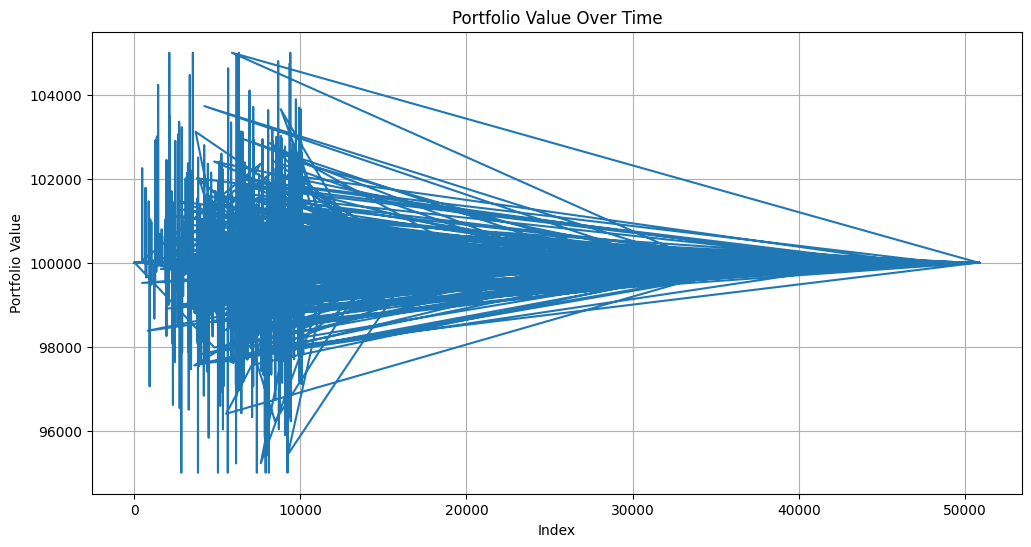

In [39]:
import matplotlib.pyplot as plt

# Make predictions on the test set
X_test['Predicted_Return'] = model.predict(X_test)

# Combine predictions with test data
X_test['Return'] = y_test.values

# Define the trading strategy
def simple_trading_strategy(predicted_return, threshold=0):
    if predicted_return > threshold:
        return 1  # Buy
    elif predicted_return < -threshold:
        return -1  # Sell
    else:
        return 0  # Hold

# Apply the trading strategy
X_test['Action'] = X_test['Predicted_Return'].apply(simple_trading_strategy)

# Simulate the trading strategy
initial_capital = 100000  # Starting with $100,000
X_test['Portfolio_Value'] = initial_capital
X_test['Position'] = 0  # Starting with no position

max_position_size = 1  # Cap on the maximum position size to prevent overflow

for i in range(1, len(X_test)):
    if X_test['Action'].iloc[i] == 1:  # Buy
        X_test.at[i, 'Position'] = min(X_test['Position'].iloc[i-1] + 1, max_position_size)
    elif X_test['Action'].iloc[i] == -1:  # Sell
        X_test.at[i, 'Position'] = max(X_test['Position'].iloc[i-1] - 1, -max_position_size)
    else:  # Hold
        X_test.at[i, 'Position'] = X_test['Position'].iloc[i-1]
    
    # Cap the return to prevent overflow
    capped_return = np.clip(X_test['Return'].iloc[i], -0.05, 0.05)
    
    # Update portfolio value
    X_test.at[i, 'Portfolio_Value'] = float(X_test['Portfolio_Value'].iloc[i-1]) * (1 + capped_return * X_test['Position'].iloc[i])

# Calculate key performance metrics
total_return = (X_test['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital
sharpe_ratio = (X_test['Return'].mean() * 252) / (X_test['Return'].std() * np.sqrt(252))
max_drawdown = (X_test['Portfolio_Value'].max() - X_test['Portfolio_Value'].min()) / X_test['Portfolio_Value'].max()

print(f'Total Return: {total_return * 100:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Maximum Drawdown: {max_drawdown * 100:.2f}%')

# Plot the portfolio value
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, X_test['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Index')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()


In [41]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


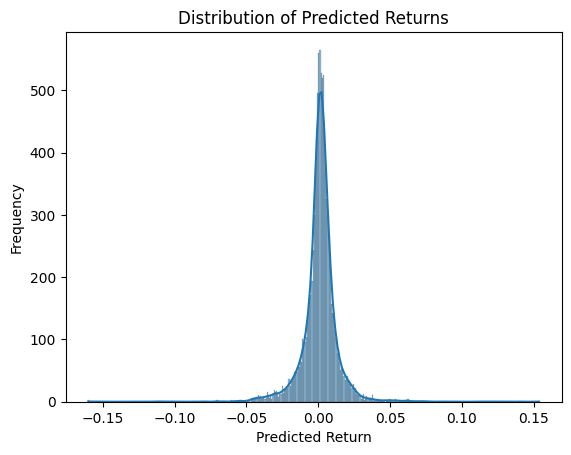

In [42]:
import seaborn as sns

# Analyze the distribution of predicted returns
sns.histplot(X_test['Predicted_Return'], kde=True)
plt.title('Distribution of Predicted Returns')
plt.xlabel('Predicted Return')
plt.ylabel('Frequency')
plt.show()


C:\Users\rahul\AppData\Local\Temp\ipykernel_29416\1141947076.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99518.85106781435' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.at[i, 'Portfolio_Value'] = float(X_test['Portfolio_Value'].iloc[i-1]) * (1 + capped_return * X_test['Position'].iloc[i])


Total Return: nan%
Sharpe Ratio: 0.90
Maximum Drawdown: 9.52%


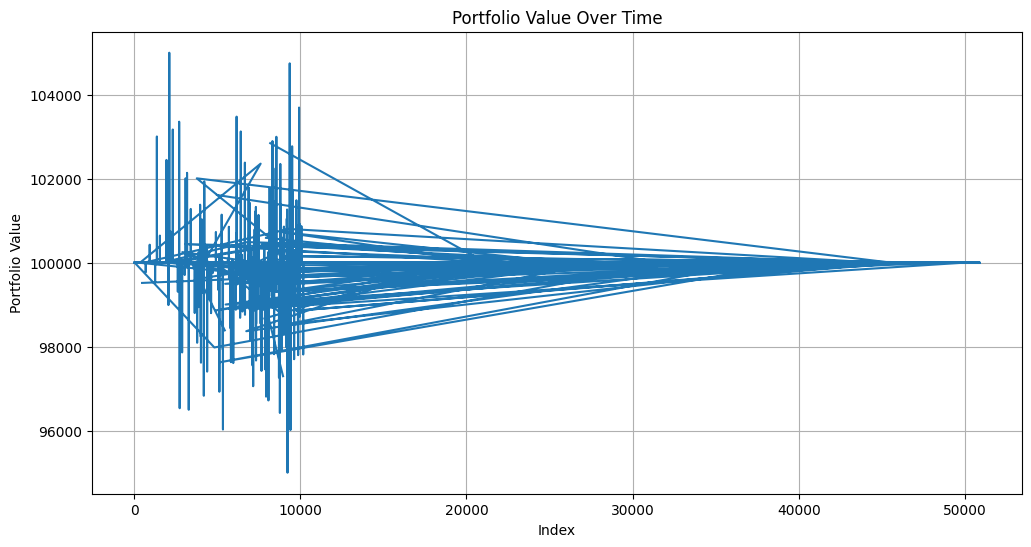

In [43]:
# Adjust the trading strategy to use a more appropriate threshold
def refined_trading_strategy(predicted_return, threshold=0.01):
    if predicted_return > threshold:
        return 1  # Buy
    elif predicted_return < -threshold:
        return -1  # Sell
    else:
        return 0  # Hold

# Apply the refined trading strategy
X_test['Action'] = X_test['Predicted_Return'].apply(refined_trading_strategy)

# Simulate the trading strategy with the refined logic
initial_capital = 100000  # Starting with $100,000
X_test['Portfolio_Value'] = initial_capital
X_test['Position'] = 0  # Starting with no position

max_position_size = 1  # Cap on the maximum position size to prevent overflow

for i in range(1, len(X_test)):
    if X_test['Action'].iloc[i] == 1:  # Buy
        X_test.at[i, 'Position'] = min(X_test['Position'].iloc[i-1] + 1, max_position_size)
    elif X_test['Action'].iloc[i] == -1:  # Sell
        X_test.at[i, 'Position'] = max(X_test['Position'].iloc[i-1] - 1, -max_position_size)
    else:  # Hold
        X_test.at[i, 'Position'] = X_test['Position'].iloc[i-1]
    
    # Cap the return to prevent overflow
    capped_return = np.clip(X_test['Return'].iloc[i], -0.05, 0.05)
    
    # Update portfolio value
    X_test.at[i, 'Portfolio_Value'] = float(X_test['Portfolio_Value'].iloc[i-1]) * (1 + capped_return * X_test['Position'].iloc[i])

# Calculate key performance metrics
total_return = (X_test['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital
sharpe_ratio = (X_test['Return'].mean() * 252) / (X_test['Return'].std() * np.sqrt(252))
max_drawdown = (X_test['Portfolio_Value'].max() - X_test['Portfolio_Value'].min()) / X_test['Portfolio_Value'].max()

print(f'Total Return: {total_return * 100:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Maximum Drawdown: {max_drawdown * 100:.2f}%')

# Plot the portfolio value
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, X_test['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Index')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()


In [44]:
# Check model performance on the training set
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f'Training MSE: {train_mse}')
print(f'Training R^2: {train_r2}')


Training MSE: 4.70729058755516e-05
Training R^2: 0.9031191470688288


C:\Users\rahul\AppData\Local\Temp\ipykernel_29416\1141947076.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99518.85106781435' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.at[i, 'Portfolio_Value'] = float(X_test['Portfolio_Value'].iloc[i-1]) * (1 + capped_return * X_test['Position'].iloc[i])


Total Return: nan%
Sharpe Ratio: 0.90
Maximum Drawdown: 9.52%


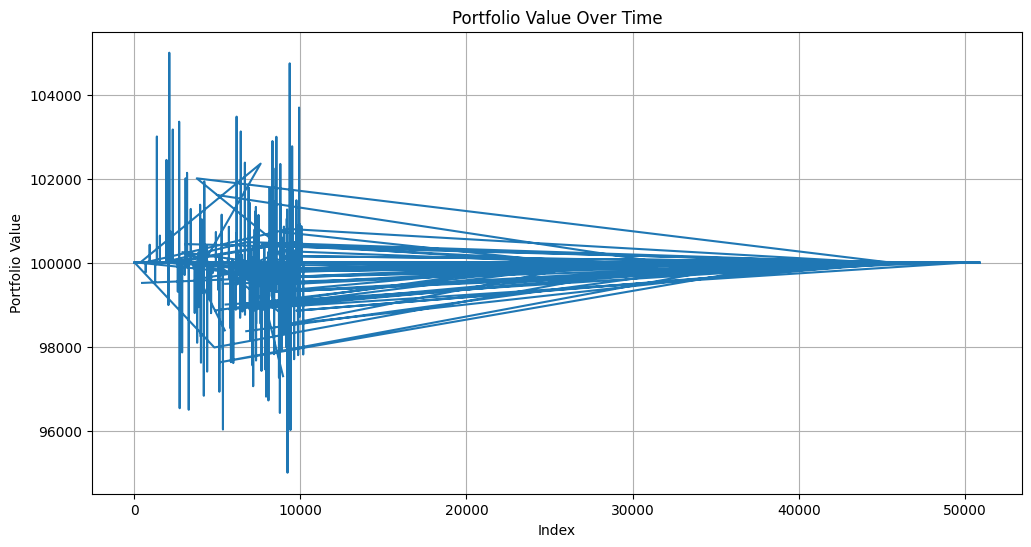

In [45]:
# Adjust the trading strategy to use a more appropriate threshold
def refined_trading_strategy(predicted_return, threshold=0.01):
    if predicted_return > threshold:
        return 1  # Buy
    elif predicted_return < -threshold:
        return -1  # Sell
    else:
        return 0  # Hold

# Apply the refined trading strategy
X_test['Action'] = X_test['Predicted_Return'].apply(refined_trading_strategy)

# Simulate the trading strategy with the refined logic
initial_capital = 100000  # Starting with $100,000
X_test['Portfolio_Value'] = initial_capital
X_test['Position'] = 0  # Starting with no position

max_position_size = 1  # Cap on the maximum position size to prevent overflow

for i in range(1, len(X_test)):
    if X_test['Action'].iloc[i] == 1:  # Buy
        X_test.at[i, 'Position'] = min(X_test['Position'].iloc[i-1] + 1, max_position_size)
    elif X_test['Action'].iloc[i] == -1:  # Sell
        X_test.at[i, 'Position'] = max(X_test['Position'].iloc[i-1] - 1, -max_position_size)
    else:  # Hold
        X_test.at[i, 'Position'] = X_test['Position'].iloc[i-1]
    
    # Cap the return to prevent overflow
    capped_return = np.clip(X_test['Return'].iloc[i], -0.05, 0.05)
    
    # Update portfolio value
    X_test.at[i, 'Portfolio_Value'] = float(X_test['Portfolio_Value'].iloc[i-1]) * (1 + capped_return * X_test['Position'].iloc[i])

# Calculate key performance metrics
total_return = (X_test['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital
sharpe_ratio = (X_test['Return'].mean() * 252) / (X_test['Return'].std() * np.sqrt(252))
max_drawdown = (X_test['Portfolio_Value'].max() - X_test['Portfolio_Value'].min()) / X_test['Portfolio_Value'].max()

print(f'Total Return: {total_return * 100:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Maximum Drawdown: {max_drawdown * 100:.2f}%')

# Plot the portfolio value
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, X_test['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Index')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()


In [51]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# Load the test data
test_data_path = 'data/processed/feature_engineered_dataset.parquet'
X_test = pd.read_parquet(test_data_path)

# Load the ensemble model
ensemble_model = joblib.load('data/processed/best_ensemble_model.pkl')

# Separate 'Return' column from test data
y_test = X_test['Return']
X_test = X_test.drop(columns=['Date', 'Ticker', 'Return'])

# Make predictions on the test set
X_test['Predicted_Return'] = ensemble_model.predict(X_test)

# Re-add 'Return' column for subsequent operations
X_test['Return'] = y_test


In [52]:
# Refined trading strategy with threshold and capped returns
def refined_trading_strategy(predicted_return, threshold=0.01):
    if predicted_return > threshold:
        return 1  # Buy
    elif predicted_return < -threshold:
        return -1  # Sell
    else:
        return 0  # Hold

# Apply the refined trading strategy
X_test['Action'] = X_test['Predicted_Return'].apply(refined_trading_strategy)


In [53]:
# Initialize the simulation
initial_capital = 100000  # Starting with $100,000
X_test['Portfolio_Value'] = initial_capital
X_test['Position'] = 0  # Starting with no position

max_position_size = 10  # Cap on the maximum position size to prevent overflow

# Simulate trading strategy
for i in range(1, len(X_test)):
    if X_test['Action'].iloc[i] == 1:  # Buy
        X_test.at[i, 'Position'] = min(X_test['Position'].iloc[i-1] + 1, max_position_size)
    elif X_test['Action'].iloc[i] == -1:  # Sell
        X_test.at[i, 'Position'] = max(X_test['Position'].iloc[i-1] - 1, -max_position_size)
    else:  # Hold
        X_test.at[i, 'Position'] = X_test['Position'].iloc[i-1]
    
    # Cap the return to prevent overflow
    capped_return = np.clip(X_test['Return'].iloc[i], -0.05, 0.05)
    
    # Update portfolio value
    X_test.at[i, 'Portfolio_Value'] = float(X_test['Portfolio_Value'].iloc[i-1]) * (1 + capped_return * X_test['Position'].iloc[i])

# Calculate key performance metrics
total_return = (X_test['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital
sharpe_ratio = (X_test['Return'].mean() * 252) / (X_test['Return'].std() * np.sqrt(252))
max_drawdown = (X_test['Portfolio_Value'].max() - X_test['Portfolio_Value'].min()) / X_test['Portfolio_Value'].max()

print(f'Total Return: {total_return * 100:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Maximum Drawdown: {max_drawdown * 100:.2f}%')


C:\Users\rahul\AppData\Local\Temp\ipykernel_29416\3760485460.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '102598.06725635707' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.at[i, 'Portfolio_Value'] = float(X_test['Portfolio_Value'].iloc[i-1]) * (1 + capped_return * X_test['Position'].iloc[i])


Total Return: -100.00%
Sharpe Ratio: 0.81
Maximum Drawdown: 100.00%


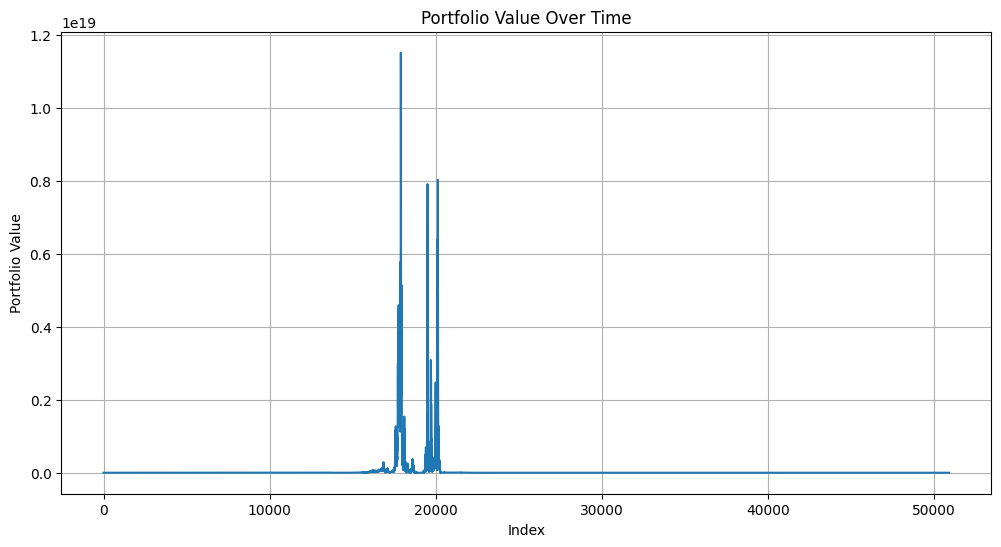

In [54]:
# Plot the portfolio value
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, X_test['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Index')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()
